## co-localization calculations for the for 74 RNA processing factors

#### co-localization.py calculates vectors of occupancies per transcript

In [1]:
import itertools
import sys
import numpy as np
import pandas as pd
import os
import collections
import matplotlib.pyplot as plt
from collections import defaultdict
import argparse
import re
from scipy.stats.stats import pearsonr
import matplotlib.patches as patches

#### set these variables:

In [2]:
home_dir = '/home/salma/Coding/scratch/'

pipeline_dir = os.path.join(home_dir, 'pipeline')
analysis_dir = os.path.join(home_dir, 'analysis/co_localization')
plotting_dir = os.path.join(home_dir, 'plots/co_localization')

brange = 40 #range of overlap taken into account. (should be a subset of the values calculated in co-localization.py)

In [3]:
#load data list

data_summary = pd.read_table(os.path.join(home_dir, 'data_summary.txt'), header=None) # a table of deta which gets processed including pathway information

data_summary.columns=['factor','pathway','group']
data_summary.index = data_summary.factor
factors = data_summary.factor

### Calculations

In [4]:
# in summary: co-localization.py does this on different chromosomes in parallel:

def occupancy_near_factor (dir_base_factor_table, dir_sec_factor_table, base_range):
    b_qtable = pd.read_table( dir_base_factor_table, sep='\t')
    b_qtable = b_qtable.rename(columns= {'seqid' : 'chrom'})
    b_qtable = b_qtable.rename(columns= {'position' : 'start'})
    b_qtable = b_qtable[['chrom','start','strand', 'occupancy']]

    s_qtable = pd.read_table( dir_sec_factor_table, sep='\t')
    s_qtable = s_qtable.rename(columns= {'seqid' : 'chrom'})
    s_qtable = s_qtable.rename(columns= {'position' : 'start'})
    s_qtable = s_qtable[['chrom','start','strand', 'occupancy']]

    params = defaultdict(list)
    for i,f in b_qtable.iloc[0:10000].iterrows():
        params['chrom'].extend([f.chrom] * (base_range*2 + 1))
        params['strand'].extend([f.strand] * (base_range*2 + 1))
        params['occupancy'].extend([f.occupancy] * (base_range*2 + 1))
        params['id'].extend([i] * (base_range*2 + 1))
        for i in range(-1*base_range,base_range + 1):
            params['start'].append(f.start + i)

    d_param = pd.DataFrame(params)     


    df_merged = d_param.merge(s_qtable, on=['chrom', 'start', 'strand'], how='left').fillna(0)

    occ_vectors = []
    for dfid, site_df in df_merged.groupby("id"):
        occ_vectors.append(np.array(site_df['occupancy_y']))

    occ_vector = np.vstack(occ_vectors).sum(axis=0)
    return occ_vector

factor co_localization vectors are computed by cluster and saved in analysis directory

In [5]:
#reads all occupancy files in a directory and returns a list of values around the center summed over [-brange, brange] - [0]

def read_occupancies_wo_center(analysis_dir, brange):
    occ_files = os.listdir(analysis_dir)
    all_values = list()
    for occ_file in occ_files:
        try:
            with open(os.path.join(analysis_dir,occ_file), "r") as f:
                lines = f.readlines()
            dir1 = re.compile(r'dir1=([^\s]+)').search(lines[0]).group(1)
            dir2 = re.compile(r'dir2=([^\s]+)').search(lines[0]).group(1)
            occupancy = [float(i) for i in lines[1].split()]
            middle = int((len(occupancy)-1)/2)
            sum_occ = sum(occupancy[middle-brange:middle-1]) + sum(occupancy[middle+2:middle+brange+1])
            all_values.append([dir1, dir2, sum_occ])
        except:
            print(occ_file)
    return all_values

In [6]:
# building a co-localization dataframe to plot the heatmap

def read_and_process(brange):
    all_coloc = read_occupancies_wo_center(analysis_dir, brange)

    facs = set([x[0] for x in all_coloc])
    co_loc = pd.DataFrame(columns= facs, index=facs)

    for loc in all_coloc:
        co_loc.loc[loc[0], loc[1]] = loc[2]
        co_loc.loc[loc[1], loc[0]] = loc[2] #writing half of the matrix is enough

    co_loc.rename(columns=lambda x: x.split('-')[0], inplace=True)
    co_loc.index = [s.split('-')[0] for s in co_loc.index]
    co_loc = co_loc[factors].reindex(factors)
    return co_loc

In [7]:
co_loc = read_and_process(brange)

#check if all files are computed | prints number of unavalable calculations
co_loc.isna().sum().sum()


0

In [8]:
#manually saturate color pallette 
from matplotlib.colors import LinearSegmentedColormap

orig_cmap = plt.cm.BuPu
newcmap = LinearSegmentedColormap.from_list('newcmap', list(map(orig_cmap,np.linspace(-0.1, 1.1, 150))))

In [9]:
#plotting function

%matplotlib inline
import seaborn as sns; sns.set(color_codes=True)

def plot_correlation_heatmap (data, colormap = plt.cm.viridis, clustering = False, filename = 'aplothasnoname.got', savefile = False, title = '',
                              robust = True, heatmapkws=dict(), all_factors=False):   
    if all_factors:
        colors = ['m', 'darkblue', 'darkolivegreen', 'xkcd:pink', 'xkcd:maroon', 'c', 'xkcd:purple', 'r', 'g', 'xkcd:orange', 'b', '#C2BC87']
        factors = data_summary.factor
        groups = data_summary.group
        pathways = data_summary.pathway
        g_names = data_summary.pathway.unique()
        lut = dict(zip(pathways.unique(), colors))
        pw_colors = [lut[x] for x in pathways]        
    else:    
        pathways_of_interest = ['Deadenylation', 'Decapping', 'Xrn1', 'Exosome',  'NMD']
        factors = data_summary.loc[data_summary.pathway.isin(pathways_of_interest), 'factor']
        groups = data_summary.loc[data_summary.pathway.isin(pathways_of_interest), 'group']
        pathways = data_summary.loc[data_summary.pathway.isin(pathways_of_interest), 'pathway']
        colors = ['r', 'g', 'xkcd:orange', 'b', '#C2BC87']
        lut = dict(zip(pathways.unique(), colors))
        pw_colors = [lut[x] for x in pathways]
    
    data_plot = data.loc[factors, factors]
        
    sns.set(rc={'font.size': 10, 'axes.labelsize': 12, 'legend.fontsize': 12, 
        'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
 
    g = sns.clustermap(data_plot, cmap=colormap, metric='correlation',row_cluster=clustering ,col_cluster=clustering,
                       row_colors=pw_colors, col_colors=pw_colors, robust=robust, **heatmapkws, figsize=(len(factors)/3, len(factors)/3))
    
    ax = g.ax_heatmap
    lines = np.append(0, np.cumsum([sum(data_summary.pathway==p) for p in pathways.unique()]))
    lineskw = dict(edgecolor='#15151c', linewidth=3)
    for i in range(len(lines)-1):
        ax.add_patch(
            patches.Rectangle(
                (lines[i], lines[i]),
                lines[i+1]-lines[i],
                lines[i+1]-lines[i],
                fill=False,      # remove background
                **lineskw
            )
        )

    
    plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

    g.fig.suptitle(title)

    #legend:
    for pw in pathways.unique():
        g.ax_col_dendrogram.bar(0, 0, color=lut[pw],
                                label=pw, linewidth=0)
    lgd = g.ax_col_dendrogram.legend(bbox_to_anchor=(1.55, 1), loc=1 )
    
    if(savefile):
        plt.savefig(os.path.join(plotting_dir, filename),
                bbox_extra_artists=(lgd,), bbox_inches='tight')


In [10]:
savefile = True
heatmapkws = dict(square=True, linewidths=0.4, linecolor='#15151c') 

### raw co-localization heatmaps

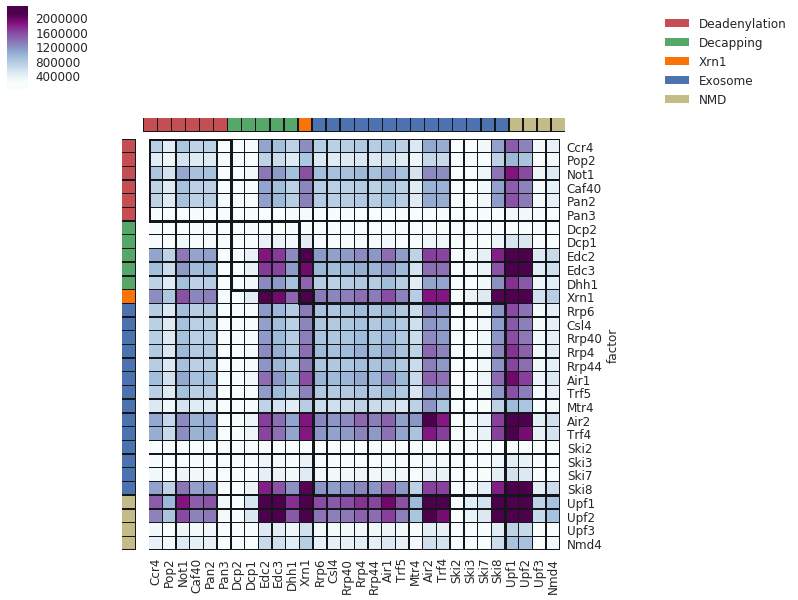

In [11]:
plot_correlation_heatmap(co_loc.fillna(0), colormap=newcmap, clustering=False, 
                         filename= 'co_localization_' + str(brange) + '.pdf', savefile=savefile, heatmapkws=heatmapkws)

In [12]:
rowsum = co_loc.sum(axis=0)
colsum = co_loc.sum(axis=1)
co_loc_normed = co_loc.div(rowsum, axis=0)
co_loc_normed = co_loc_normed.div(colsum, axis=1)
co_loc_normed = co_loc_normed #*(max(rowsum)*max(colsum))

co_loc_normed_log = pd.DataFrame([np.log2(x) for x in co_loc_normed.values.tolist()], columns=list(co_loc_normed.columns.values))
co_loc_normed_log.index = factors

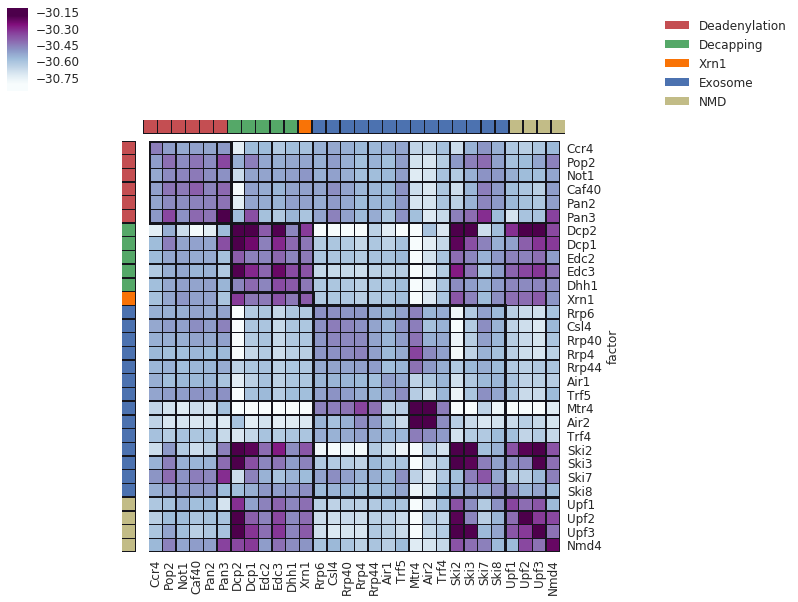

In [13]:
plot_correlation_heatmap(co_loc_normed_log.fillna(0), colormap=newcmap, clustering=False, 
                         filename= 'co_localization_normed_' + str(brange) + '.pdf', savefile=savefile, heatmapkws=heatmapkws)

In [14]:
heatmapkws = dict(square=True, linewidths=0.5, linecolor='#15151c' , vmin=-1.1, vmax=1.1) 

### correlation heatmaps

In [15]:
pearson_corr = [[pearsonr(co_loc_normed.iloc[:,i].values, co_loc_normed.iloc[:,j].values)[0]\
                 for j in range(len(factors))] for i in range(len(factors))]

pearson_corr = pd.DataFrame(pearson_corr, columns= factors, index = factors)

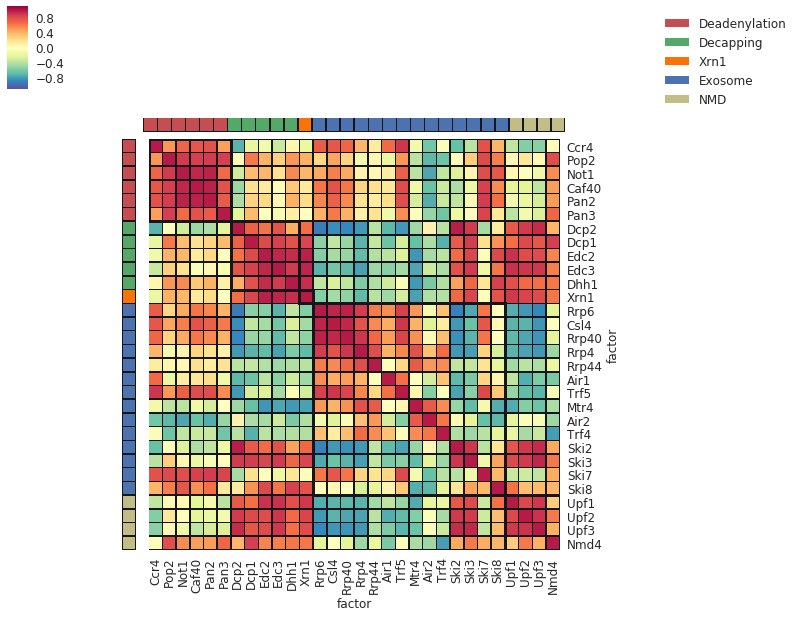

In [16]:
plot_correlation_heatmap(pearson_corr, colormap= 'Spectral_r', clustering=False, filename= 'correlation_' + str(brange) + '.pdf', 
                         savefile=savefile, heatmapkws=heatmapkws)

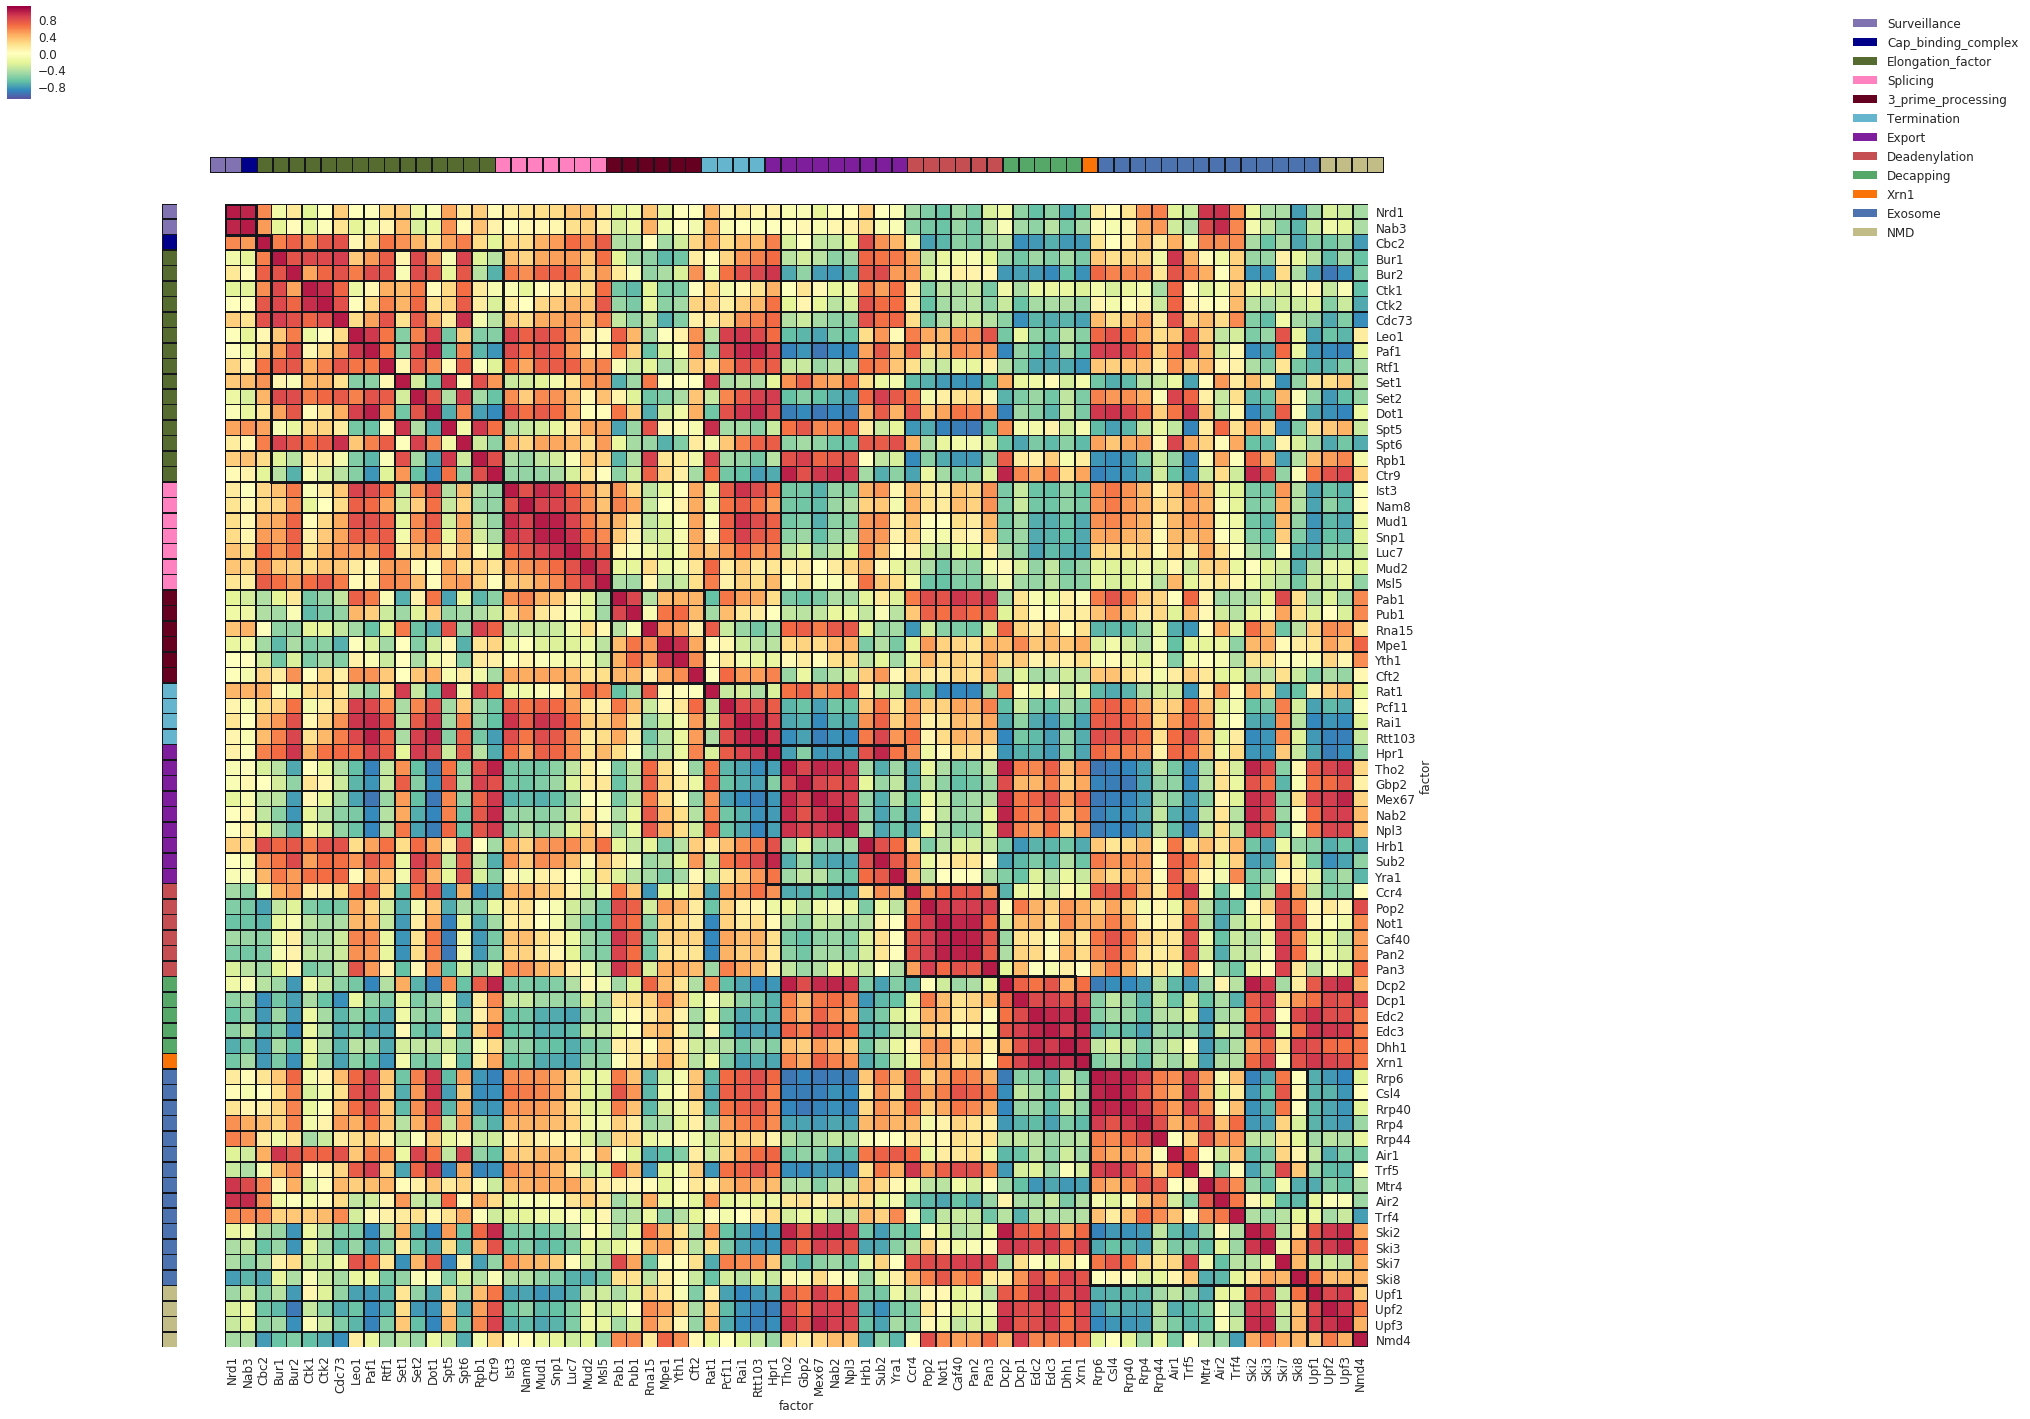

In [17]:
plot_correlation_heatmap(pearson_corr, colormap= 'Spectral_r', clustering=False, filename= 'correlation_' + str(brange) + '_all.pdf', 
                         savefile=savefile, heatmapkws=heatmapkws, all_factors=True)

In [18]:
colors = ['m', 'darkblue', 'darkolivegreen', 'xkcd:pink', 'xkcd:maroon', 'c', 'xkcd:purple', 'r', 'g', 'xkcd:orange', 'b', '#C2BC87']
factors = data_summary.factor
groups = data_summary.group
pathways = data_summary.pathway
g_names = data_summary.pathway.unique()
lut = dict(zip(pathways.unique(), colors))
pw_colors = [lut[x] for x in pathways]

### tSNE plots:
#### tSNE plots with randomly initialized variables have consistent topologies

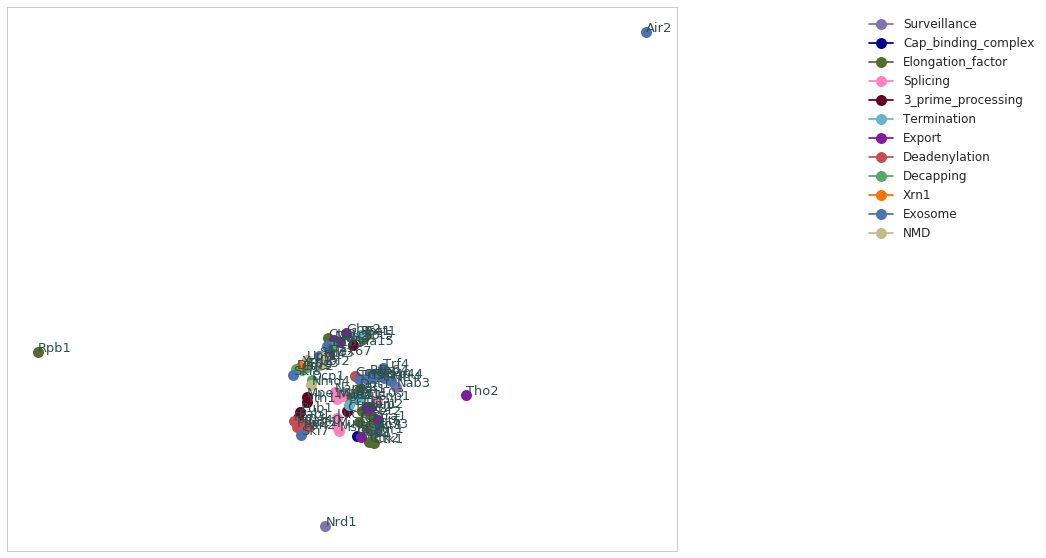

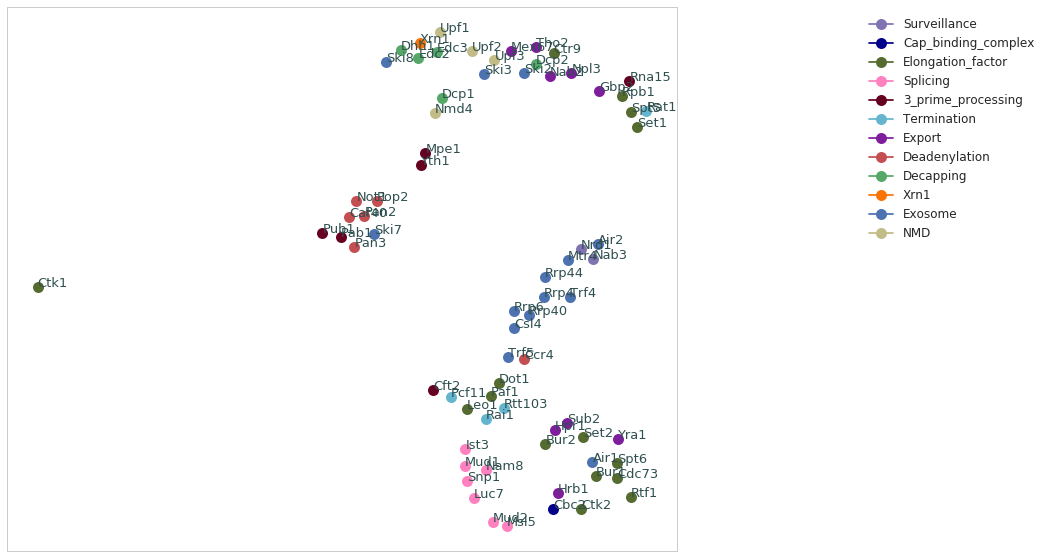

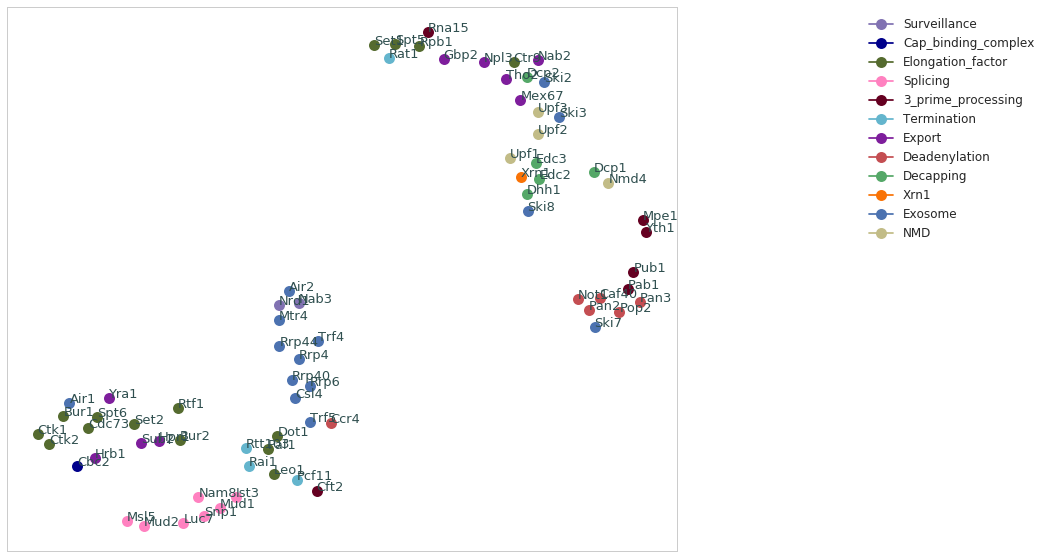

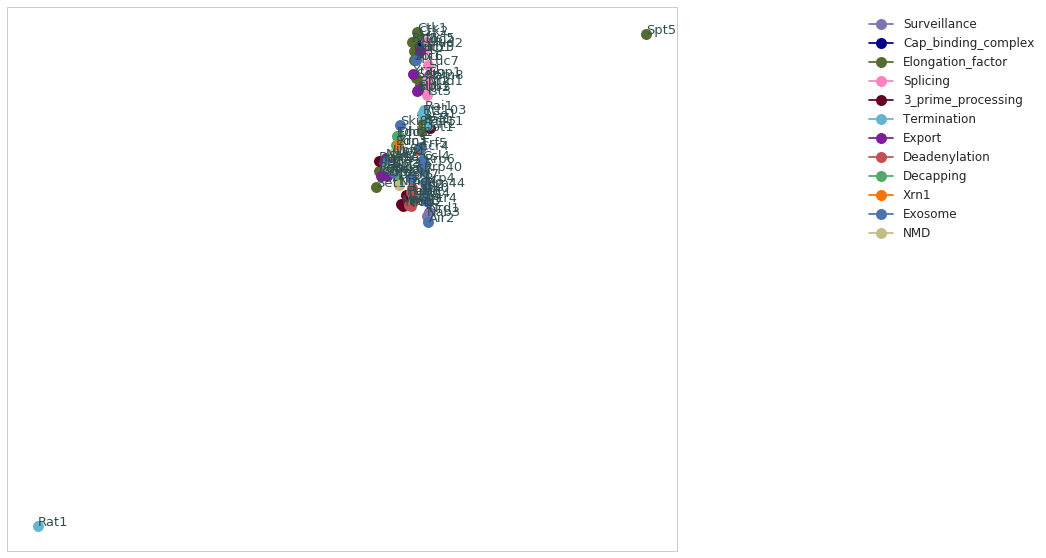

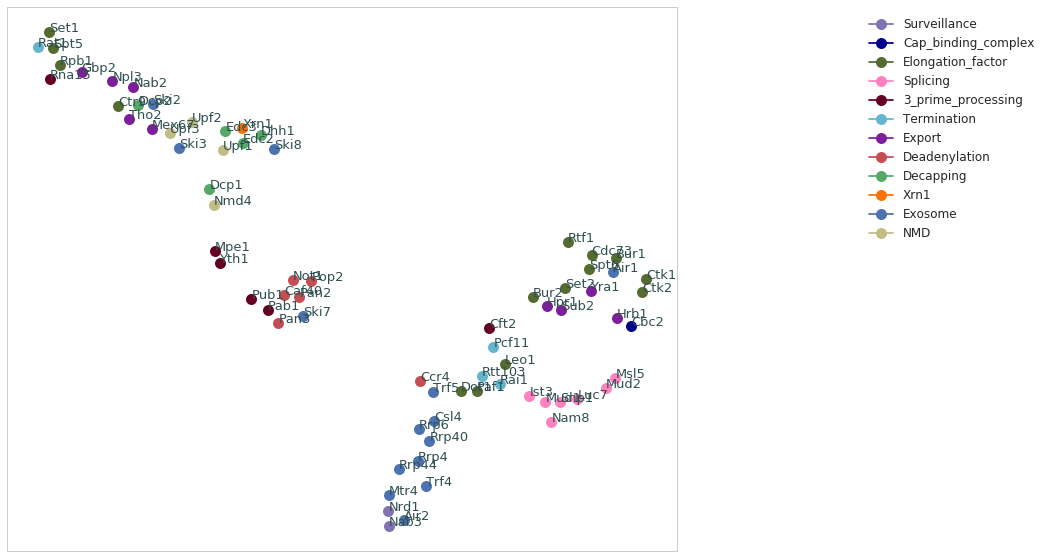

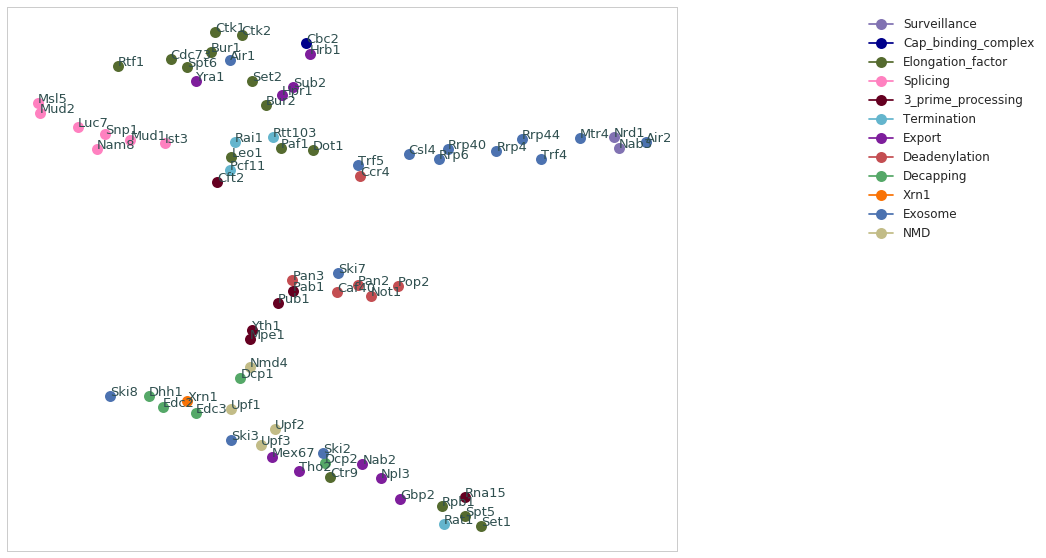

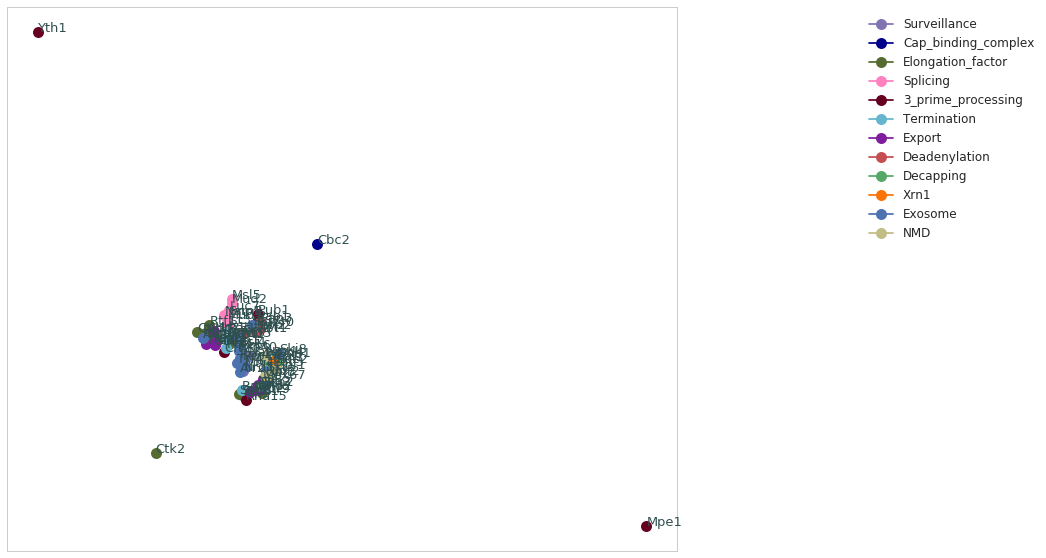

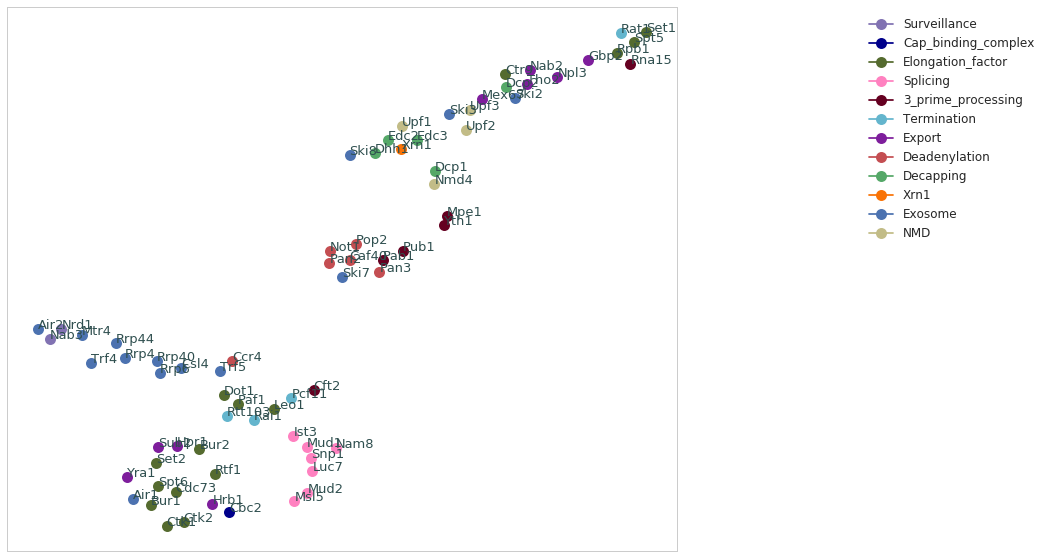

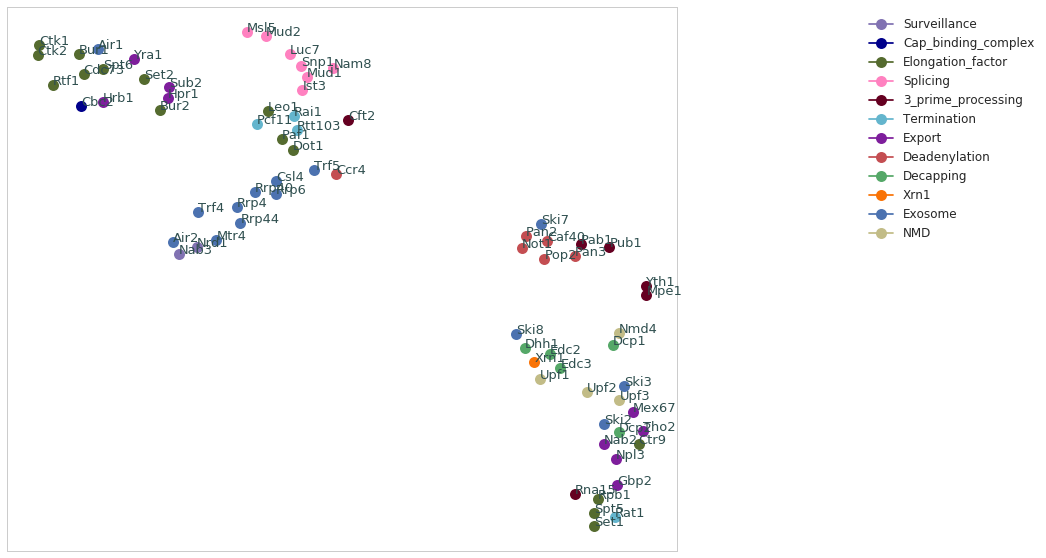

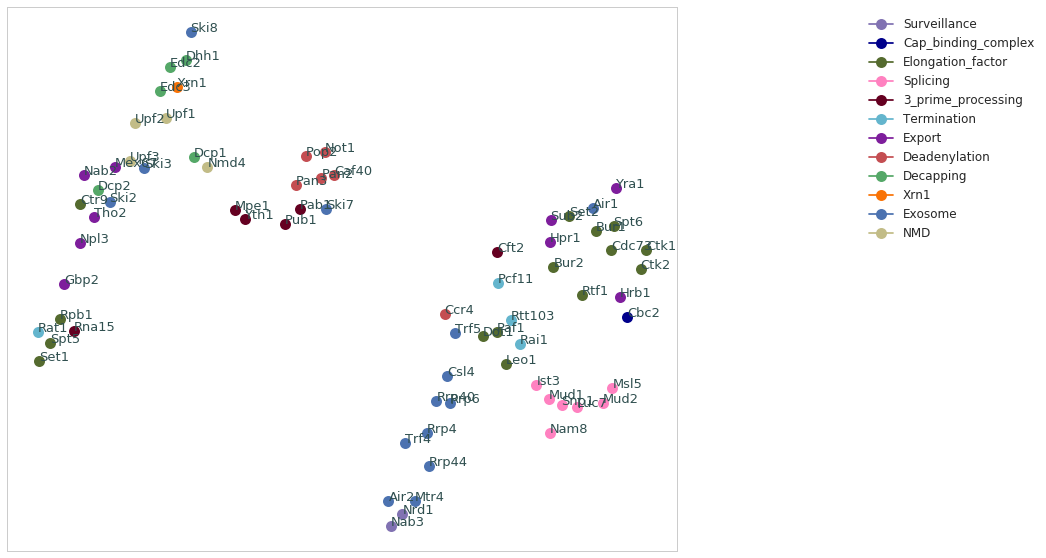

In [19]:
from sklearn.preprocessing import normalize
from sklearn import manifold

sns.set_style("whitegrid", {'axes.grid' : False})

for j in range(10):
    model = manifold.TSNE(n_components=2, metric='precomputed', perplexity=6, n_iter = 8000)
    coords = model.fit_transform(1 - pearson_corr)

    fig, ax = plt.subplots(facecolor='w')
    fig.set_size_inches(12,10)

    for i, text in enumerate(factors):
        x = coords[i][0]
        y = coords[i][1]
        plt.plot(x, y, color = pw_colors[i],  marker='o', markersize=11, label=pathways[i])
        plt.text(x,y , text , fontsize=13, color='#2F4F4F')

    ax.xaxis.set_ticklabels([])   
    ax.yaxis.set_ticklabels([])
    lgd = ax.legend(bbox_to_anchor=(1.55, 1), loc=1)
    plt.savefig(os.path.join(plotting_dir,'tSNE', 'tSNE_correlation_%d.pdf' % (j)), bbox_extra_artists=(lgd,), bbox_inches='tight')
    #plt.close()
